In [30]:
#this analysis is done on the citizens of Phoenix import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [35]:
data = pd.read_csv(r"C:\Users\IdeaP\Downloads\diabetes (1).csv")
df = data.copy()

In [40]:
df.shape

(768, 9)

In [41]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [43]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [44]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.900,0.171,63,0
764,2,122,70,27,0,36.800,0.340,27,0
765,5,121,72,23,112,26.200,0.245,30,0
766,1,126,60,0,0,30.100,0.349,47,1
767,1,93,70,31,0,30.400,0.315,23,0


In [45]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [46]:
df.quantile([0, 0.05,0.1, 0.25, 0.50,0.75, 0.90, 0.95, 0.99, 1]).T

,0.000,0.050,0.100,0.250,0.500,0.750,0.900,0.950,0.990,1.000
Pregnancies,0.000,0.000,0.000,1.000,3.000,6.000,9.000,10.000,13.000,17.000
Glucose,0.000,79.000,85.000,99.000,117.000,140.250,167.000,181.000,196.000,199.000
BloodPressure,0.000,38.700,54.000,62.000,72.000,80.000,88.000,90.000,106.000,122.000
SkinThickness,0.000,0.000,0.000,0.000,23.000,32.000,40.000,44.000,51.330,99.000
Insulin,0.000,0.000,0.000,0.000,30.500,127.250,210.000,293.000,519.900,846.000
BMI,0.000,21.800,23.600,27.300,32.000,36.600,41.500,44.395,50.759,67.100
DiabetesPedigreeFunction,0.078,0.140,0.165,0.244,0.372,0.626,0.879,1.133,1.698,2.420
Age,21.000,21.000,22.000,24.000,29.000,41.000,51.000,58.000,67.000,81.000
Outcome,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000


In [47]:
df.groupby(['Outcome']).agg({"Age":["mean", "median"],
                            "Glucose":["mean","median"],
                            "Pregnancies":["mean", "median"],
                            "BMI":["mean", "median"],
                            "SkinThickness":["mean", "median"]})

Age        Glucose        Pregnancies           BMI        SkinThickness       
          mean median    mean median        mean median   mean median          mean median
Outcome                                                                                   
0       31.190     27 109.980    107       3.298      2 30.304 30.050        19.664     21
1       37.067     36 141.257    140       4.866      4 35.143 34.250        22.164     27

In [48]:
print(f"Observations: {df.shape[0]}")

Observations: 768


In [51]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


   Outcome  Ratio
0      500 65.104
1      268 34.896


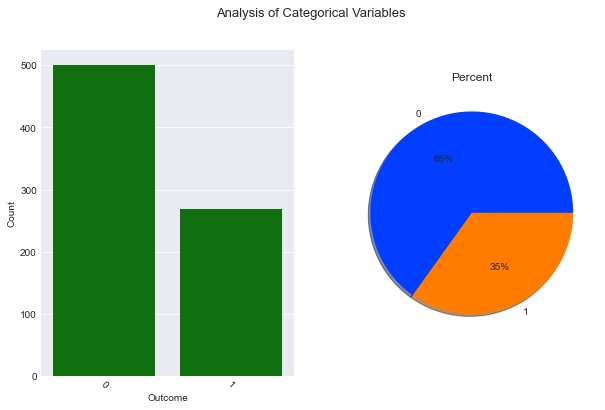

In [52]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        plt.style.use('seaborn-darkgrid')
        fig, ax = plt.subplots(1, 2)
        ax = np.reshape(ax, (1, 2))
        ax[0, 0] = sns.countplot(x=dataframe[col_name], color="green", ax=ax[0, 0])
        ax[0, 0].set_ylabel('Count')
        ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=-45)
        ax[0, 1] = plt.pie(dataframe[col_name].value_counts().values, labels=dataframe[col_name].value_counts().keys(),
                           colors=sns.color_palette('bright'), shadow=True, autopct='%.0f%%')
        plt.title("Percent")
        fig.set_size_inches(10, 6)
        fig.suptitle('Analysis of Categorical Variables', fontsize=13)
        plt.show()


for col in cat_cols:
    cat_summary(df, col, plot=True)

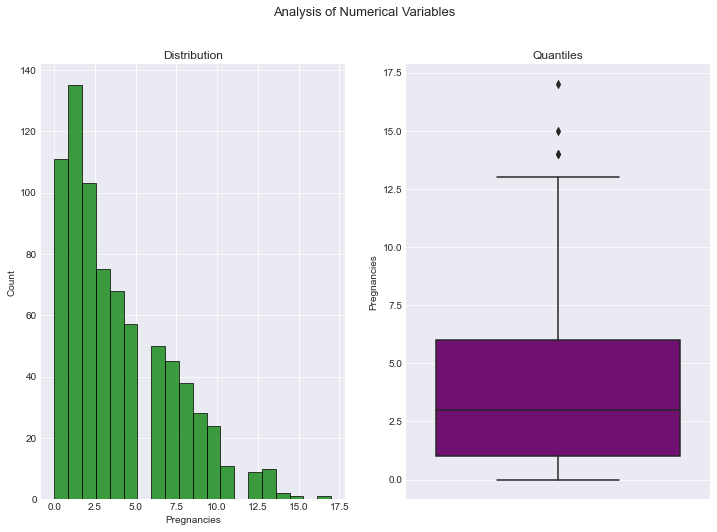

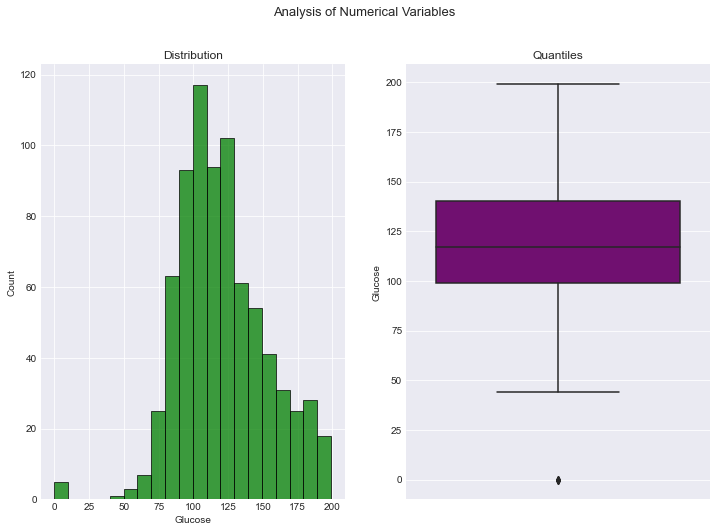

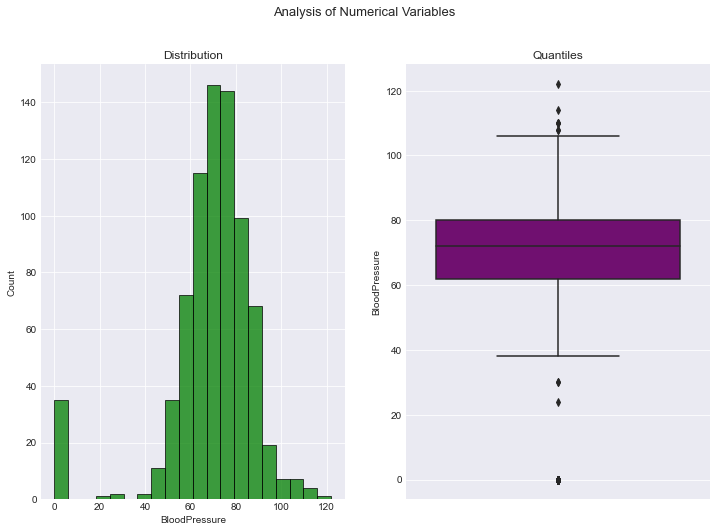

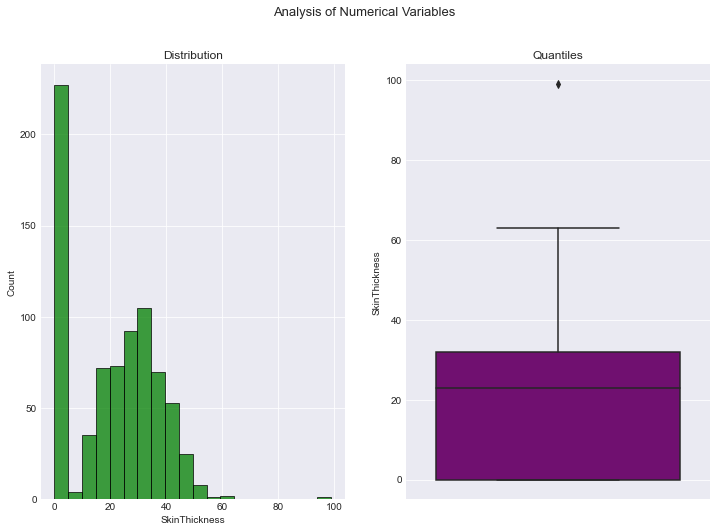

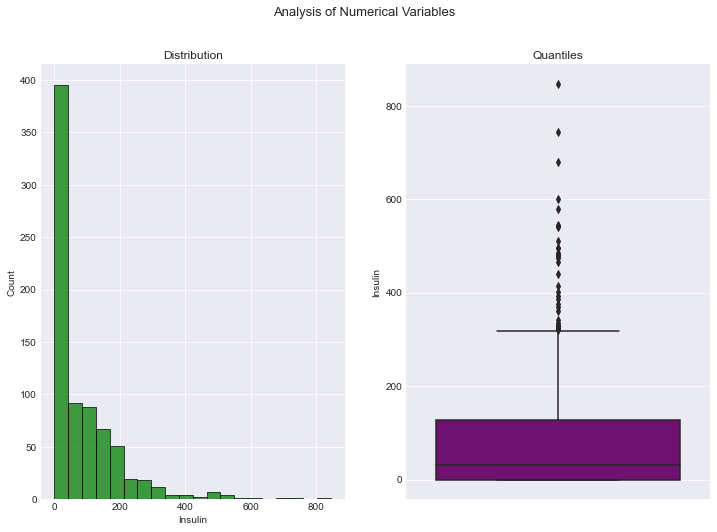

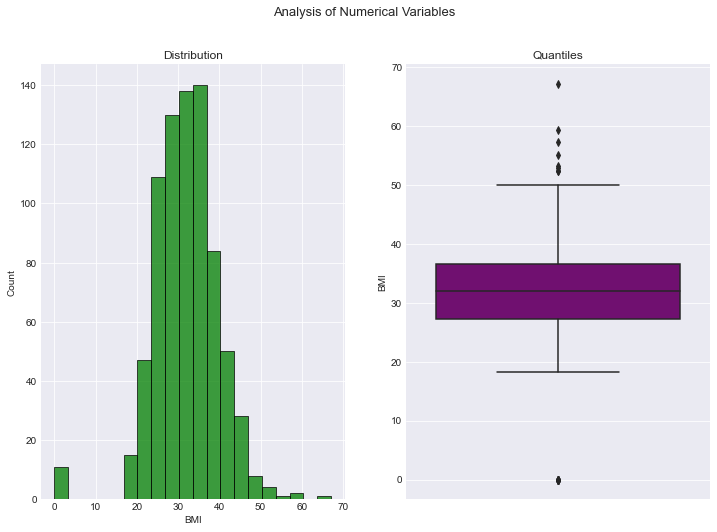

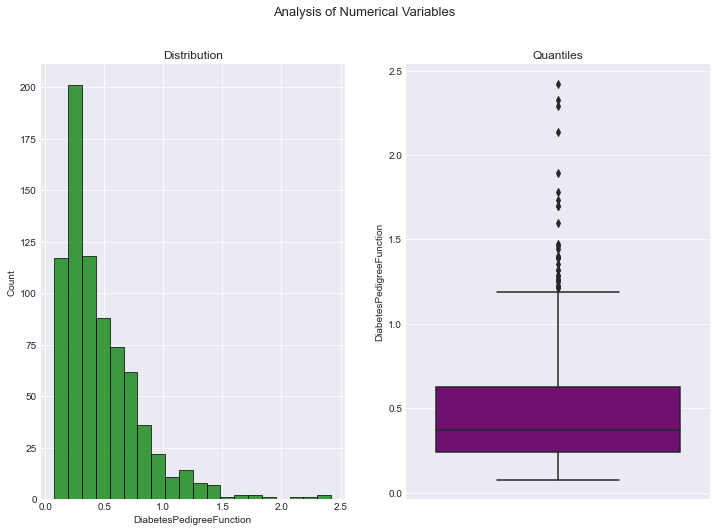

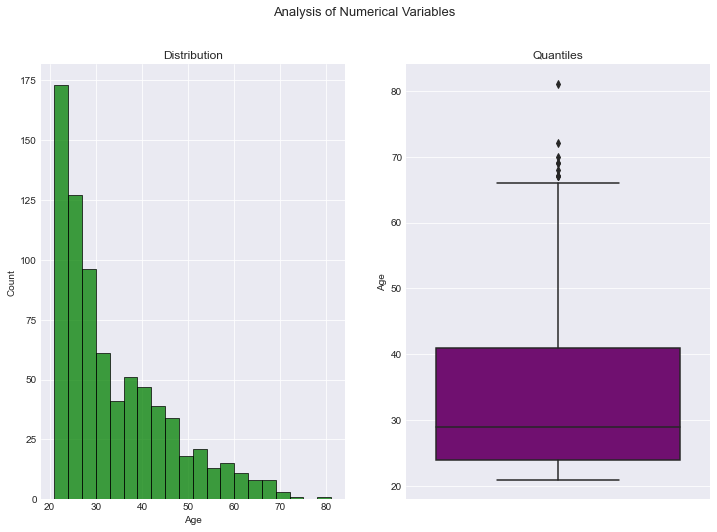

In [53]:
def num_summary(dataframe, numerical_col):
    # setup the plot grid
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(1, 2)
    ax = np.reshape(ax, (1, 2))
    ax[0, 0] = sns.histplot(x=dataframe[numerical_col], color="green", bins=20, ax=ax[0, 0])
    ax[0, 0].set_ylabel('Count')
    ax[0, 0].set_title('Distribution')
    ax[0, 1] = sns.boxplot(y=dataframe[numerical_col], color="purple", ax=ax[0, 1])
    ax[0, 1].set_title('Quantiles')

    fig.set_size_inches(12, 8)
    fig.suptitle('Analysis of Numerical Variables', fontsize=13)
    plt.show()

for col in df[num_cols]:
    num_summary(df, col)

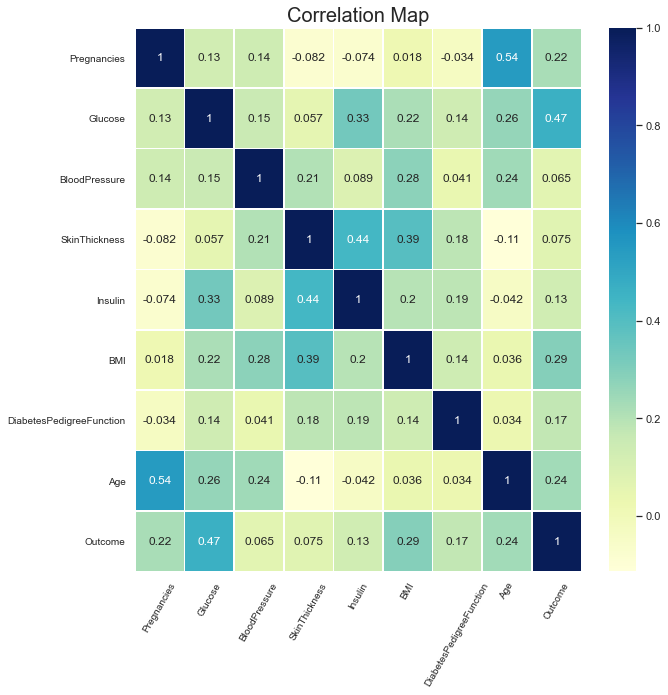

In [54]:
def correlated_map(dataframe, plot=False):
    corr = dataframe.corr()
    if plot:
        sns.set(rc={'figure.figsize': (10, 10)})
        sns.heatmap(corr, cmap="YlGnBu", annot=True, linewidths=.7)
        plt.xticks(rotation=60, size=10)
        plt.yticks(size=10)
        plt.title('Correlation Map', size=20)
        plt.show()

correlated_map(df, plot=True)

In [55]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
missing_values_table(df, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


[]

In [56]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

for col in num_cols:
    print(outlier_thresholds(df, col))

(-15.0, 25.0)
(-74.0, 334.0)
(-38.249999999999986, 166.95)
(-66.0, 110.0)
(-439.5, 732.5)
(-12.09249999999999, 78.2875)
(-1.3483999999999996, 2.621599999999999)
(-34.5, 113.5)


In [58]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
    replace_with_thresholds(df,col)

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.637,114.243,0.000,0.000,30.500,127.250,732.500
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


                 BMI_Cat  Ratio
obesity_class_1      221 28.776
overweight           180 23.438
obesity_class_2      148 19.271
normal_weight        108 14.062
obesity_class_3       96 12.500
underweight           15  1.953


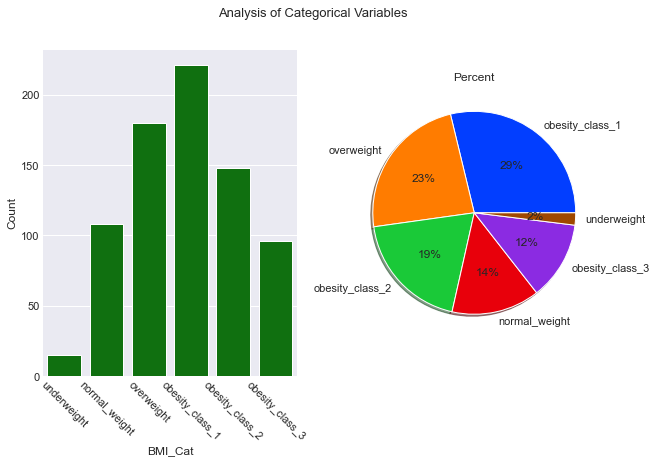

In [60]:
bmi_labels = ["underweight", "normal_weight", "overweight", "obesity_class_1", "obesity_class_2", "obesity_class_3"]
df['BMI_Cat'] = pd.cut(df['BMI'], [-1, 18.5, 25, 30, 35, 40, df['BMI'].max()], 
                       labels=bmi_labels)
cat_summary(df,"BMI_Cat", plot=True)

            New_Age_Cat  Ratio
youngmale           396 51.562
maturemale          291 37.891
seniormale           81 10.547


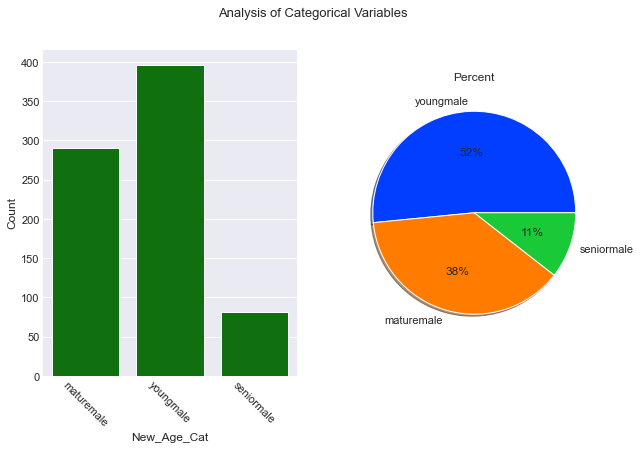

In [61]:
df["New_Age_Cat"] = df["Age"].apply(lambda x: "youngmale" if x < 30 else ("maturemale" if 30 <= x <= 50 else "seniormale"))
cat_summary(df,"New_Age_Cat", plot=True)

        Glucose_Cat  Ratio
Normal          571 74.349
IGT             197 25.651


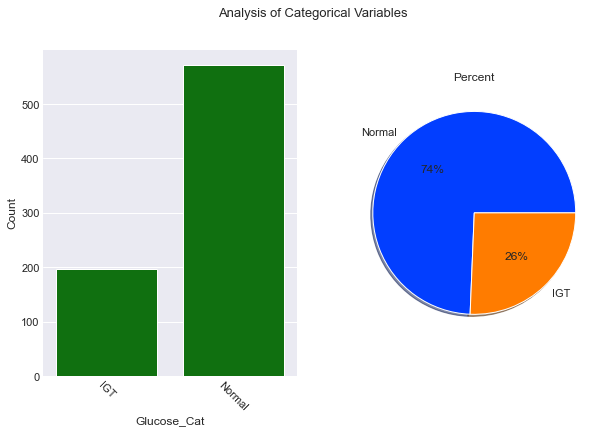

In [62]:
df["Glucose_Cat"] = df["Glucose"].apply(lambda x: "Normal" if x < 140 else ("IGT" if 140 <= x <= 200 else "DM"))
cat_summary(df,"Glucose_Cat", plot=True)

                      Blood_Pressure_Cat  Ratio
optimal                              603 78.516
high_normal                           68  8.854
normal                                59  7.682
grade_1_hypertension                  25  3.255
grade_2_hypertension                  11  1.432
grade_3_hypertension                   2  0.260


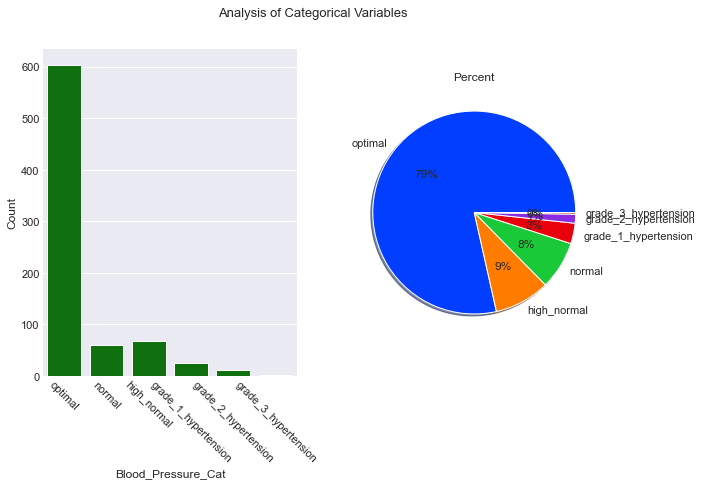

In [63]:
bp_labels = ["optimal", "normal", "high_normal", "grade_1_hypertension", "grade_2_hypertension", "grade_3_hypertension"]
df['Blood_Pressure_Cat'] = pd.cut(df['BloodPressure'], [-1, 80,  85, 90, 100, 110, df['BloodPressure'].max()], labels=bp_labels)
cat_summary(df,"Blood_Pressure_Cat", plot=True)

In [64]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
len(binary_cols)

2

In [65]:
for col in binary_cols:
    label_encoder(df, col)

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Cat,New_Age_Cat,Glucose_Cat,Blood_Pressure_Cat
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1,obesity_class_1,maturemale,0,optimal
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0,overweight,maturemale,1,optimal
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1,normal_weight,maturemale,0,optimal
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,overweight,youngmale,1,optimal
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,obesity_class_3,maturemale,1,optimal


In [66]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_Cat,BMI_Cat_normal_weight,BMI_Cat_overweight,BMI_Cat_obesity_class_1,BMI_Cat_obesity_class_2,BMI_Cat_obesity_class_3,New_Age_Cat_seniormale,New_Age_Cat_youngmale,Blood_Pressure_Cat_normal,Blood_Pressure_Cat_high_normal,Blood_Pressure_Cat_grade_1_hypertension,Blood_Pressure_Cat_grade_2_hypertension,Blood_Pressure_Cat_grade_3_hypertension
0,6.000,148.000,72.000,35.000,0.000,33.600,0.627,50.000,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.000,85.000,66.000,29.000,0.000,26.600,0.351,31.000,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2,8.000,183.000,64.000,0.000,0.000,23.300,0.672,32.000,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0.000,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,1,0,0,0,0,1,0,0,0,0,0,0,0


In [67]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 22
cat_cols: 14
num_cols: 8
cat_but_car: 0
num_but_cat: 14


In [68]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

check_df(df)

########################### Shape ###########################
(768, 22)
########################### Types ###########################
Pregnancies                                float64
Glucose                                    float64
BloodPressure                              float64
SkinThickness                              float64
Insulin                                    float64
BMI                                        float64
DiabetesPedigreeFunction                   float64
Age                                        float64
Outcome                                      int64
Glucose_Cat                                  int32
BMI_Cat_normal_weight                        uint8
BMI_Cat_overweight                           uint8
BMI_Cat_obesity_class_1                      uint8
BMI_Cat_obesity_class_2                      uint8
BMI_Cat_obesity_class_3                      uint8
New_Age_Cat_seniormale                       uint8
New_Age_Cat_youngmale                        uint8

In [69]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

In [70]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [71]:
y_pred = log_model.predict(X)

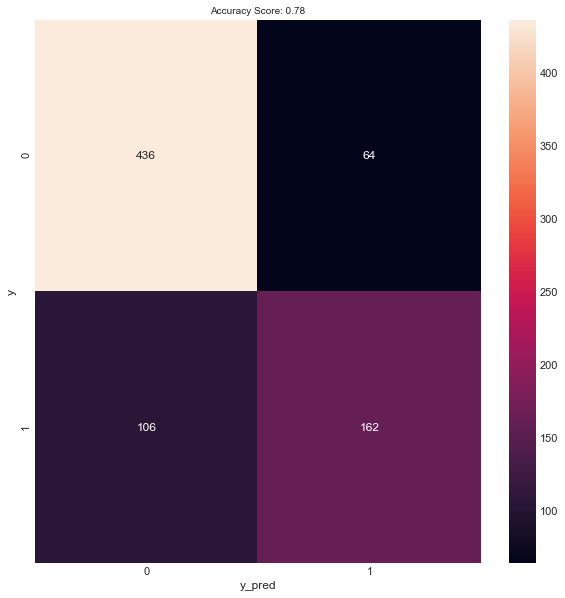

In [72]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [73]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       500
           1       0.72      0.60      0.66       268

    accuracy                           0.78       768
   macro avg       0.76      0.74      0.75       768
weighted avg       0.77      0.78      0.77       768



In [74]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8544626865671641

In [75]:
X.columns

random_user = X.sample(1, random_state=42)

log_model.predict(random_user)

array([0], dtype=int64)

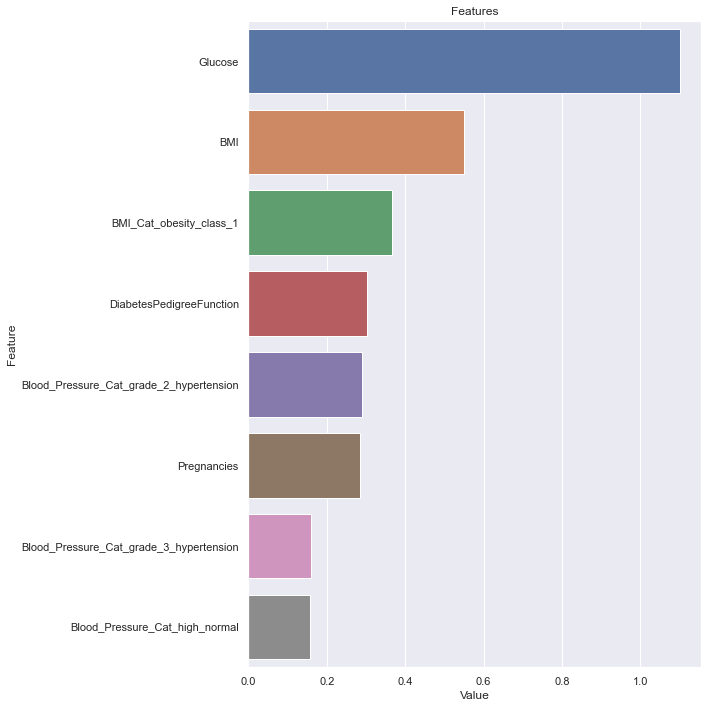

In [76]:
feature_imp = pd.DataFrame({'Value': log_model.coef_[0], 'Feature': X.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()